In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hridaym25/burgers-equation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/burgers-equation-dataset


In [36]:
from scipy.io import loadmat                   # Import function to load MATLAB .mat files
import os                                      # Import for handling file paths
import jax.numpy as jnp                        # Import JAX's NumPy for array operations

file_to_load = os.path.join(path, 'burgers_shock.mat')  # Create full path to the .mat file

data = loadmat(file_to_load)                  # Load the .mat file as a dictionary
x_data = data['x']                             # Extract spatial grid 'x' from the file
y_data = data['usol']                          # Extract solution matrix 'usol' (u(x,t)) as target
y_data = jnp.asarray(y_data)                   # Convert target data to JAX array
x_data = jnp.asarray(x_data)                   # Convert input data to JAX array

In [37]:
def u_i(i):
    return y_data[:, i]       # Returns the solution u(x, t_i) at time index i (all spatial points)

def x_i(i):
    return x_data[i]          # Returns the spatial coordinate at index i

In [38]:
from flax import nnx
import jax
import jax.numpy as jnp

# Moderate custom initializer
def moderate_init(key, shape, dtype=jnp.float32):
    return jax.random.normal(key, shape, dtype) * 1.5  # Not too large

# Branch network
class Branch(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(256, 100, kernel_init=moderate_init, rngs=rngs)
        self.linear2 = nnx.Linear(100, 40, kernel_init=moderate_init, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

# Trunk network
class Trunk(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(1, 40, kernel_init=moderate_init, rngs=rngs)
        self.linear2 = nnx.Linear(40, 40, kernel_init=moderate_init, rngs=rngs)
        self.linear3 = nnx.Linear(40, 40, kernel_init=moderate_init, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = nnx.tanh(self.linear2(x))
        x = self.linear3(x)
        return x

# DeepONet with dot-product fusion
class DeepONet(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.branch_net = Branch(rngs=rngs)
        self.trunk_net = Trunk(rngs=rngs)

    def __call__(self, x, y):
        b_out = self.branch_net(x)
        t_out = self.trunk_net(y)
        return jnp.vdot(b_out, t_out)

# Instantiate model
model = DeepONet(rngs=nnx.Rngs(0))

# Optional: Visualize structure
nnx.display(model)

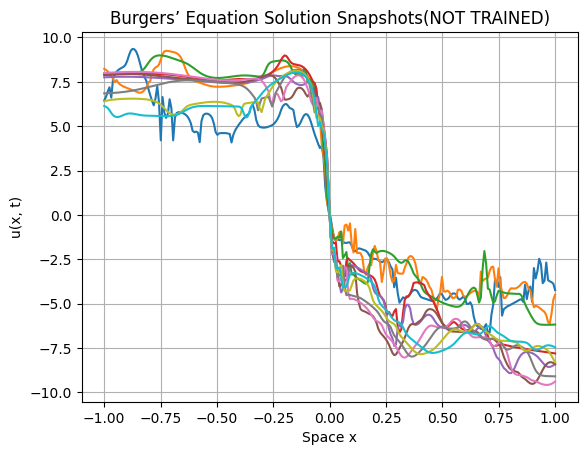

In [39]:
import jax.numpy as jnp                    # JAX-compatible NumPy
import jax                                # JAX core library
import matplotlib.pyplot as plt           # For plotting

# One step of RK4 method for u(x) at a given spatial point x_i
def rk4_step(model, u_i, x_i, x_data, h=0.01):
    index = jnp.argmin(jnp.abs(x_data - x_i))      # Find closest index in x_data to x_i
    y_value = u_i[index]

    k1 = model(u_i, x_i)
    k2 = model(u_i + 0.5 * h * k1, x_i)
    k3 = model(u_i + 0.5 * h * k2, x_i)
    k4 = model(u_i + h * k3, x_i)

    return y_value + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)  # Weighted sum (RK4 formula)

# Vectorized RK4 over all spatial points in x_data
def rk4_vmap(model, u_i, x_i, x_data, h=0.01):
    return jax.vmap(rk4_step, in_axes=(None, None, 0, None, None))(model, u_i, x_data, x_data, h)

# Apply RK4 time stepping and plot for time snapshots
for i in range(0, 100, 10):
    t = rk4_vmap(model, u_i(i), x_data, x_data)
    plt.plot(x_data, t)

plt.xlabel('Space x')
plt.ylabel('u(x, t)')
plt.title('Burgers’ Equation Solution Snapshots(NOT TRAINED)')
plt.grid(True)
plt.show()

In [40]:
def loss_fn(model, u_i, x_i, x_data, truth, h=0.01):
    u_i1 = rk4_vmap(model, u_i, x_i, x_data, h)    # Predict next time step using RK4
    return jnp.mean((u_i1 - truth)**2)             # Mean squared error loss

In [41]:
@nnx.jit
def train_step(model,u_i, x_i, x_data,truth,h=0.01):
    grad_fn = nnx.value_and_grad(loss_fn)  # calculate grads
    loss ,grads = grad_fn(model,u_i, x_i, x_data,truth,h=0.01)
    return grads, loss


In [42]:
import optax

learning_rate = 0.05
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum)) # Adam_optimizer
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [49]:
import matplotlib.pyplot as plt

train_mse = []
num_epochs = 100            # Total training epochs
# epoch_loss = []

for epoch in range(num_epochs):
    for i in range(49):     # Train from t=0 to t=0.49 (49 steps)
        grads, loss = train_step(model, u_i(i), x_data, x_data, u_i(i+1), h=0.01)  # Compute gradients and loss
        train_mse.append(loss)       # Store loss
        optimizer.update(grads=grads)  # Update model parameters

    t = jnp.array(train_mse)
    mean_value = np.mean(t)         # Average loss over inner loop
    train_mse.clear()               # Clear for next epoch
    epoch_loss.append(mean_value)   # Store epoch-level loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {mean_value}")
    if mean_value < 5.9e-5:
        print("Stopping early due to low loss.")
        break

Epoch 1/100, Loss: 6.285985000431538e-05
Epoch 2/100, Loss: 0.0019129232969135046
Epoch 3/100, Loss: 8.891705510905012e-05
Epoch 4/100, Loss: 5.562025398830883e-05
Stopping early due to low loss.


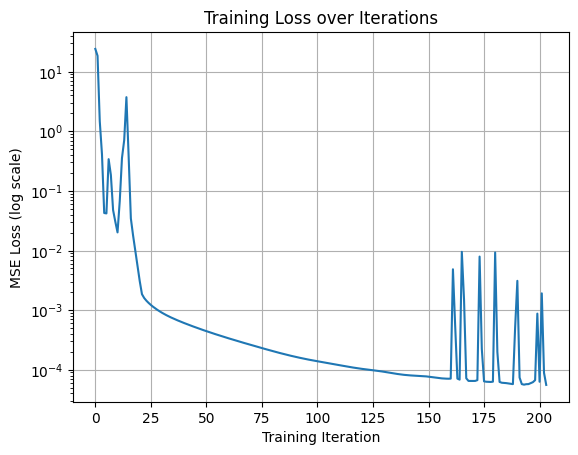

In [50]:
import matplotlib.pyplot as plt

plt.semilogy(epoch_loss, linestyle='-')
plt.xlabel("Training Iteration")
plt.ylabel("MSE Loss (log scale)")
plt.title("Training Loss over Iterations")
plt.grid(True)
plt.show()

In [51]:
test_loss = []

# Extrapolation from t = 0.5 to t = 0.99 (future time steps)
for i in range(50, 99, 1):
    l = loss_fn(model, u_i(i), x_data, x_data, u_i(i+1), h=0.01)  # Compute test loss at each step
    test_loss.append(l)

Mean Test Loss: 0.00018872575310524553


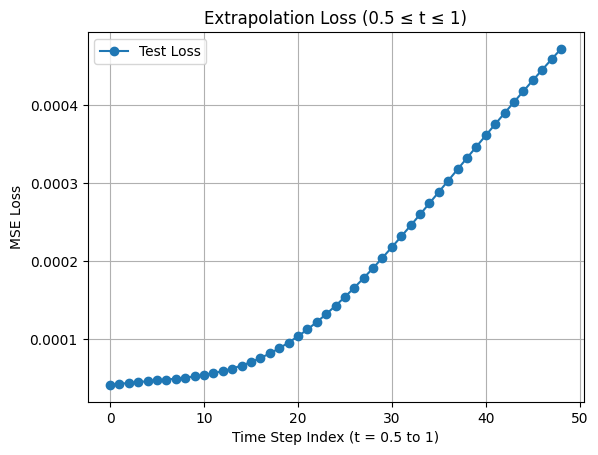

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Compute and print mean test loss
mean_test_loss = np.mean(test_loss)
print(f"Mean Test Loss: {mean_test_loss}")

# Plot test loss over extrapolated time steps
plt.plot(test_loss, marker='o', linestyle='-', label='Test Loss')
plt.xlabel("Time Step Index (t = 0.5 to 1)")
plt.ylabel("MSE Loss")
plt.title("Extrapolation Loss (0.5 ≤ t ≤ 1)")
plt.grid(True)
plt.legend()
plt.show()

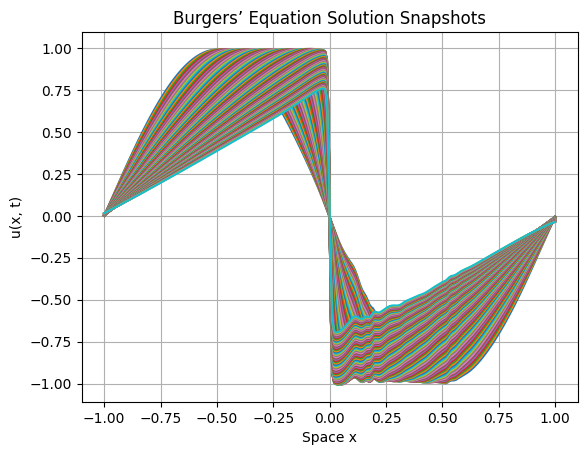

In [53]:
# Apply RK4 time stepping and plot for time snapshots
for i in range(0, 100, 1):
    t = rk4_vmap(model, u_i(i), x_data, x_data)
    plt.plot(x_data, t)

plt.xlabel('Space x')
plt.ylabel('u(x, t)')
plt.title('Burgers’ Equation Solution Snapshots')
plt.grid(True)
plt.show()